In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import math
import matplotlib.pyplot as plt
from libwallerlab.projects.motiondeblur import blurkernel

# Overview
This notebook explores a SNR vs. acquisition time analysis for strobed illumination, stop and stare, and coded illumination acquisition strategies.

First, we determine a relationship between t_frame (frame rate) and t_exposure (exposure time). Then, we relate t_exposure to SNR for each method. These relationships should be smooth but non-linear.

In [2]:
# Define constants
ps = 6.5e-3 #mm
mag = 20
ps_eff = ps / mag #um
n_px = np.asarray([2100, 2500])
fov = n_px * ps_eff
motion_axis = 0
motion_velocity_mm_s = 20
motion_acceleration_mm_s_s = 1e4

t_settle = 0.1   #s
t_ro     = 0.01  #s

figure_directory = '/Users/zfphil/Desktop/figures/'
!mkdir -p /Users/zfphil/Desktop/figures/

In [3]:
def genBlurVector_rand(kernel_length, beta=0.5, n_tests=10, metric='dnf'):
    '''
    This is a helper function for solving for a blur vector in terms of it's condition #
    '''
    kernel_list = []
    n_elements_max = math.floor(beta * kernel_length)
    for test in range(n_tests):
        indicies = np.random.permutation(kernel_length)
        kernel = np.zeros(kernel_length)
        kernel[indicies[:n_elements_max]] = 1.0
        
#         indicies = np.arange(kernel_length)
#         for index in range(n_elements_max):
#             rand_index = np.random.randint(0, high=np.size(indicies)-1, size=1)
#             kernel[indicies[rand_index]] = 1.
#             indicies = np.delete(indicies, rand_index)

        rand_index = np.random.permutation(kernel_length)[n_elements_max]
        kernel[rand_index] = beta * kernel_length - np.sum(kernel)
        assert beta * kernel_length - np.sum(kernel) <= 1
        kernel_list.append(kernel)

    if metric == 'cond':
        # Determine kernel with best conditioon #
        metric_best = 1e10
        kernel_best = []
        for kernel in kernel_list:
            spectra = np.abs(np.fft.fft(kernel))
            kappa = np.max(spectra) / np.min(spectra)
            if kappa < metric_best:
                kernel_best = kernel
                metric_best = kappa
    else:
        # Determine kernel with best conditioon #
        metric_best = 1e10
        kernel_best = []
        for kernel in kernel_list:
            dnf = (np.sum(1 / np.abs(scipy.fftpack.fft(kernel)) ** 2))
            if dnf < metric_best:
                kernel_best = kernel
                metric_best = dnf

    return (metric_best, kernel_best)

# import math
# def condNumToDnf(cond, blur_length, image_size, beta=0.1):
#     dnf = ((blur_length * beta) ** 2 / cond ** 2) * math.sqrt(np.prod(image_size))
#     return dnf
    
# # condNumToDnf(40, 50, (1000,1000))
import scipy
def calcDnfFromKernel(x):
    return (np.sum(1 / np.abs(scipy.fftpack.fft(x)) ** 2))

def getOptimalDnf(kernel_size, beta=0.5, n_tests=100, metric = 'dnf'):
    dnf, x = genBlurVector_rand(kernel_size, beta=beta, n_tests=n_tests, metric=metric)
    return(calcDnfFromKernel(x))

In [15]:
def frameRateToExposure(t_frame, acquisition_strategy, motion_velocity_mm_s=10, 
                        motion_acceleration_mm_s_s=1e4, t_readout=0.01, t_settle=0.1, 
                        fov=[1,1], motion_axis=0, ps_eff_mm=6.5e-3/20, beta_coded=0.5,
                        min_strobe_time_s=10e-6):
    

    if 'strobe' in acquisition_strategy:
        t_exp_camera = t_frame - t_readout
        v = fov[motion_axis] / t_frame
        t_illum_strobe = ps_eff / v
        if t_illum_strobe < min_strobe_time_s:
            t_exp = 0
        else:
            t_exp = t_illum_strobe
            
        # No deconvolution here
        dnf = 1
        
    elif 'stop_and_stare' in acquisition_strategy:
        t_start_stop = motion_velocity_mm_s / motion_acceleration_mm_s_s
        d_start_stop = 0.5 * motion_acceleration_mm_s_s * t_start_stop ** 2 
        t_move = (fov[motion_axis] - d_start_stop) / motion_velocity_mm_s
        t_exp_camera = t_frame - t_move - t_start_stop + t_readout
        t_exp = t_exp_camera # Illumination is on the whole time
        
        # No deconvolution here
        dnf = 1
        
    elif 'code' in acquisition_strategy:
        t_exp_camera = t_frame - t_readout
        
        # Determine kernel length
        kernel_length = int(np.ceil(t_exp_camera / t_frame * fov[motion_axis] / ps_eff))
        kernel_length = max(kernel_length, 1)
        
        if kernel_length == 1:
            dnf = 1
        else:
#             dnf = blurkernel.dnfUpperBound(kernel_length, beta_coded)
            dnf = getOptimalDnf(kernel_length, beta=beta_coded, n_tests=10)
        
        t_exp_camera = t_frame - t_readout
        v = fov[motion_axis] / t_frame
        t_illum_strobe = ps_eff / v
        if t_illum_strobe < min_strobe_time_s:
            t_exp = 0
        else:
            t_exp = t_exp_camera * beta_coded
        
# #     assert t_exp > 0
    if t_exp <= 0 or t_exp_camera <= 0:
        t_exp = 0

        
    return(t_exp, dnf)

frame_time = 0.1
t_strobe, dnf_strobd = frameRateToExposure(frame_time, 'strobe', fov=fov)
snr_strobe = blurkernel.dnf2snr(dnf_strobd, t_strobe*1000)
print("Strobed illumination will have exposure time %.5f seconds and SNR %.5f" % (t_strobe, snr_strobe))

t_sns, dnf_sns = frameRateToExposure(frame_time, 'stop_and_stare', fov=fov)
snr_sns = blurkernel.dnf2snr(dnf_sns, t_sns*1000)
print("Stop-and-stare illumination will have exposure time %.5f seconds and SNR %.5f" % (t_sns, snr_sns))

t_coded, dnf_coded = frameRateToExposure(frame_time, 'code', fov=fov)
snr_coded = blurkernel.dnf2snr(dnf_coded, t_coded*1000)
print("Coded illumination will have exposure time %.5f seconds and SNR %.5f" % (t_coded, snr_coded))

Strobed illumination will have exposure time 0.00005 seconds and SNR 11.75121
Stop-and-stare illumination will have exposure time 0.04125 seconds and SNR 351.61446
Coded illumination will have exposure time 0.04500 seconds and SNR 19.06082


## Plot SNR vs Frame Rate

In [16]:
frame_rates = np.arange(1,80,0.1)
snr_strobe_list = []
snr_sns_list = []
snr_coded_list_25 = []
snr_coded_list_10 = []
snr_coded_list_50 = []
snr_coded_list_75 = []
snr_coded_list_99 = []

for index, rate in enumerate(frame_rates):
    t_frame = 1 / rate
    
    t_strobe, dnf_strobe = frameRateToExposure(t_frame, 'strobe', fov=fov)
    snr_strobe_list.append(blurkernel.dnf2snr(dnf_strobe, t_strobe*1000))

    t_sns, dnf_sns = frameRateToExposure(t_frame, 'stop_and_stare', fov=fov)
    snr_sns_list.append(blurkernel.dnf2snr(dnf_sns, t_sns*1000))

    t_coded_10, dnf_coded_10 = frameRateToExposure(t_frame, 'code', fov=fov, beta_coded=0.05)
    snr_coded_list_10.append(blurkernel.dnf2snr(dnf_coded_10, t_coded_10*1000))
    
    t_coded_50, dnf_coded_50 = frameRateToExposure(t_frame, 'code', fov=fov, beta_coded=0.5)
    snr_coded_list_50.append(blurkernel.dnf2snr(dnf_coded_50, t_coded_50*1000))
    
#     t_coded_75, dnf_coded_75 = frameRateToExposure(t_frame, 'code', fov=fov, beta_coded=0.75)
#     snr_coded_list_75.append(blurkernel.dnf2snr(dnf_coded_75, t_coded_75))
    
    t_coded_99, dnf_coded_99 = frameRateToExposure(t_frame, 'code', fov=fov, beta_coded=0.95)
    snr_coded_list_99.append(blurkernel.dnf2snr(dnf_coded_99, t_coded_99*1000))
#     snr_coded_list.append(0)
#     print("Coded illumination will have exposure time %.3f seconds and SNR %.2f" % (t_coded, snr_coded))
#     print("Finished rate %d of %d" % (index, len(frame_rates)))



/Users/zfphil/.conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


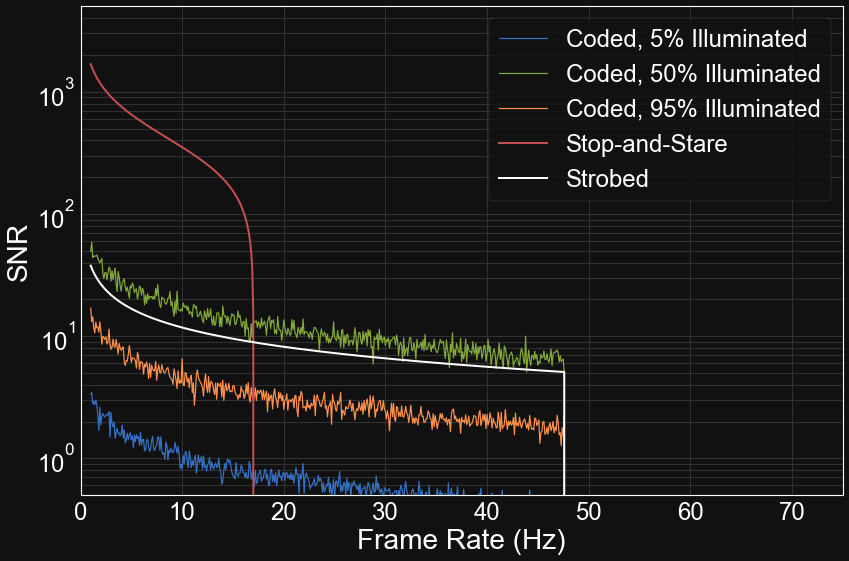

In [17]:
# plt.style.use('seaborn-dark')
jtplot.style()
# plt.style.use('classic')
plt.figure(figsize=(12,8))
plt.semilogy(frame_rates, snr_coded_list_10, 'b-')
plt.semilogy(frame_rates, snr_coded_list_50, 'g-')
plt.semilogy(frame_rates, snr_coded_list_99, 'y')
plt.semilogy(frame_rates, snr_sns_list, 'r-', linewidth=2)
plt.semilogy(frame_rates, snr_strobe_list, 'w-', linewidth=2)

plt.ylim((0.5, 5000))
plt.xlim((0,75))

plt.legend(('Coded, 5% Illuminated', 'Coded, 50% Illuminated', 'Coded, 95% Illuminated', 'Stop-and-Stare', 'Strobed'), fontsize=24)
plt.xlabel('Frame Rate (Hz)', fontsize=28)
plt.ylabel('SNR', fontsize=28)
ax = plt.gca()


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    
plt.grid('on', which='both')
plt.tight_layout()
plt.savefig(figure_directory + 'strobe_sns_coded.png', transparent=True)

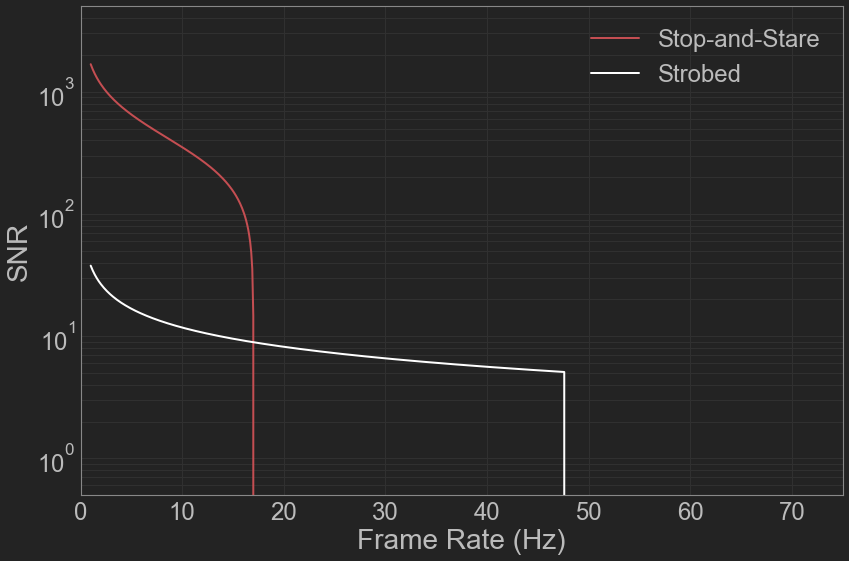

In [309]:
# plt.style.use('seaborn-dark')
jtplot.style()
# plt.style.use('classic')
plt.figure(figsize=(12,8))
plt.semilogy(frame_rates, snr_sns_list, 'r-', linewidth=2)
plt.semilogy(frame_rates, snr_strobe_list, 'w-', linewidth=2)

plt.ylim((0.5, 5000))
plt.xlim((0,75))

plt.legend(('Stop-and-Stare', 'Strobed'), fontsize=24)
plt.xlabel('Frame Rate (Hz)', fontsize=28)
plt.ylabel('SNR', fontsize=28)
ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(24)
    


plt.grid('on', which='both')
plt.tight_layout()
plt.savefig(figure_directory + 'strobe_sns.png', transparent=True)

# Blur Kernel Optimization

In [ ]:
data = np.load('single_illums.npz')
kernel_vector = data['kernel_vector']
kernel_random = data['kernel_random']
blur_kernel_map = np.zeros(object_size)

for position_index, position in enumerate(point_list):
    blur_kernel_map[position[0], position[1]] = kernel_vector[position_index]

In [ ]:
num_frames = iterates.shape[1]

iterates = np.array(result['history']['x']) #.T
print(iterates.shape)
total_its = iterates.shape[1]
interval = total_its / num_frames
#interval=2
#ax = plt.subplot2grid((6, 1), (1, 5))
#ax = plt.subplot2grid((6, 1), (1, 0), colspan=5)

initial_power_spectrum = 0;
blur_operator = W * 0.5*np.sum(kernel_map, 0).astype(np.complex64).reshape(-1)
static_power_spectrum = np.sum(np.abs(wotf.Ft(blur_operator.reshape(image_size))), axis=0)

sigma_min_static = np.amin(static_power_spectrum)
sigma_min_static = np.amax(static_power_spectrum)

# Generate spatial frequency coordintes
ps = 6.5
fov = 2000 * 6.5e-3/20
dk = 1/fov
freqs = np.arange(-len(static_power_spectrum) // 2, len(static_power_spectrum) // 2) * dk
assert len(freqs) == len(static_power_spectrum)

kernel_random = iterates[:,0]

for i in range(num_frames):
    illum = iterates[:,int(interval*i)]

    blur_operator_illum = W * (kernel_map.T.dot(iterates[:,int(interval*i)])).T.astype(np.complex64).reshape(-1)
    power_spectrum = np.sum(np.abs(wotf.Ft(blur_operator_illum.reshape(image_size))), axis=0)
    sigma_min = np.amin(power_spectrum)
    sigma_max = np.amax(power_spectrum)
    condition = sigma_max/sigma_min
    
    if i==0:
        initial_power_spectrum = power_spectrum
    
    fig = plt.figure(figsize=(10,5))
    ax1 = plt.subplot2grid((8, 1), (0, 0), rowspan=4)
    ax2 = plt.subplot2grid((8, 1), (6, 0), rowspan=2)
    
    ax2.step(illum, 'orange', linewidth=3)
    ax2.set_ylim([-0.1,1.1])
    ax2.set_xlim([0,24])
    ax2.set_title('Illumination Pattern', fontsize=24, color='w')
    ax1.set_title('Power Spectrum', fontsize=24, color='w')
#     ax1.set_xlim([0,127])
#     ax1.set_ylim([10,10^4])
#     ax2.set_xticklabels([])
    ax1.set_ylabel('Energy', color='w')
    ax1.set_xlabel('Spatial Frequencey (cycles/mm)', color='w')
    
    ax2.set_ylabel('Intensity', color='w')
    ax2.set_xlabel('Position', color='w')
    
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('none')
    #ax2.axison = False
    ax2.set_yticklabels([0,0,1])
#     ax1.semilogy(initial_power_spectrum, '--', color='white')
#     ax1.semilogy(static_power_spectrum, '--', color='white')
    ax1.semilogy(freqs, sigma_min*np.ones(power_spectrum.size), color='r', linewidth=3)
    ax1.semilogy(freqs, sigma_max*np.ones(power_spectrum.size), color='r', linewidth=3)
    ax1.semilogy(freqs, power_spectrum, color='blue', linewidth=3)
    ax1.set_ylim((10,6000))
#     ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    #plt.suptitle('iteration '+str(int(interval*i))+',\t$\kappa=$'+str(np.round(condition,3)))
    
    plt.text(0.6,4.7,'iteration '+str(int(interval*i))+', $\kappa=$'+str(np.round(condition,3)),fontsize=15, color='w')
    
    # Set Axis Colors
    for ax in [ax1, ax2]:
        ax.tick_params(axis='both', which='major', labelsize=14, color='w')
        ax.tick_params(axis='both', which='minor', labelsize=14, color='w')
        [i.set_color("w") for i in ax.get_xticklabels()]
        [i.set_color("w") for i in ax.get_yticklabels()]
    plt.savefig("images/power_spectrum_optimization" + str(i) + ".png")